## Install Libraries

In [1]:
!pip install transformers~=2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/MyDrive")

## Parameters

In [6]:
#data_path = './data/capstone/CLAWS/covidhate/annotated_tweets_w_text.csv'
data_path = './data/capstone/CLAWS/covidhate/part_labeled_tweet.csv'
#data_path = './data/part_labeled_tweet.csv'

In [7]:
trainedBertModel = 'bert'

In [8]:
batchsize = 8

In [9]:
gpu_num = 0

## Code

In [43]:
# Basic and System
import pandas as pd
import numpy as np
import time, datetime, random, glob, os, sys, joblib, argparse, json
# Torch
import torch
from torch.utils.data import TensorDataset, Subset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
# Pretrained Models
from pytorch_pretrained_bert import BertModel
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm 
# Scheduler
from transformers import get_linear_schedule_with_warmup
# OPtimizer
from transformers import AdamW
# Kfold Cross Validation
from sklearn.model_selection import KFold
# Evaluation
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [11]:
# Global Variables
USING_GPU = False
DEVICE = None

In [12]:
# Pretrained models dictionary
# Try in the future: Albert
pretrained_models = {'bert': 'bert-base-uncased', 'roberta': 'roberta-base'}

In [22]:
# Format time display
def format_time(seconds):
    seconds_round = int(round((seconds)))
    return str(datetime.timedelta(seconds=seconds_round)) # hh:mm:ss

In [13]:
# Prepare data for pytorch dataloader
def prepare_dataset(sentences, labels, tokenizer, max_length=100):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        # print(sent)
        try:
            encoded_dict = tokenizer.encode_plus(
                                sent,
                                add_special_tokens = True,
                                max_length = max_length,
                                truncation=True,
                                pad_to_max_length = True,
                                return_attention_mask = True,
                                return_tensors = 'pt'
                           )
        except:
            print("some tweet sent is not correct")
            print(sent)
            exit(0)

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [29]:
def train(fold, model, device, train_loader, optimizer, scheduler, epoch):
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_loader):
        print('step: '+str(step))
        model.zero_grad()
        
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))
        
        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].unsqueeze(0).to(DEVICE)
        #print(b_input_ids.shape)
        #print(b_input_mask.shape)
        #print(b_labels.shape)
        # https://stackoverflow.com/questions/70548318/bertforsequenceclassification-target-size-torch-size1-16-must-be-the-same
        #b_labels = torch.nn.functional.one_hot(b_labels.to(torch.int64), 3)
        #print(type(b_labels))
        #print(b_labels.shape)
        #loss, logits, hidden_states = model(b_input_ids,
        loss, logits, hidden_states = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        #print('run more')
        total_train_loss += loss.item()
        #loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        del loss, logits

    avg_train_loss = total_train_loss / len(train_loader)

    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

Add following:
validation accuracy


In [25]:
def test(fold, model, device, test_loader, test_data_len):
    print("Running Validation...")

    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    predictions, true_labels = [], []
    for batch in tqdm(test_loader, total=test_data_len):
        # b_labels are true labels
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(batch[0].to(DEVICE), token_type_ids=None,
                            attention_mask=batch[1].to(DEVICE))
            b_proba = outputs[0]
            # Accumulate the validation loss.
            total_eval_loss += b_proba.item()

            proba = b_proba.detach().cpu().numpy()
            label_ids = batch[2].numpy()

            predictions.append(proba)
            true_labels.append(label_ids)

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += accuracy_score(label_ids, b_labels)

    #print(predictions)
    print(true_labels)
    print(b_labels)

In [26]:
# Wrapper function for fine-tuning
# batch size, epochs, and learning rate are from CLAWS paper
def train_bert_model(model, dataset, batch_size, epochs=3, learning_rate=1e-5, epsilon=1e-8, save_fn=None):

    if USING_GPU:
        print("Using GPU", DEVICE)
        model.cuda(DEVICE)

    # prepare cross validation
    n_fold = 5
    kfold = KFold(n_splits=n_fold, shuffle=True)

    n_accuracy = []
    n_prescision = []
    n_recall = []
    n_f1 = []

    # for each fold
    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
        print('------------fold no---------{}----------------------'.format(fold))
        print(train_idx)
        print(test_idx)
        train_tensor = Subset(dataset, train_idx)
        test_tensor = Subset(dataset, test_idx)
        test_data_len = len(test_idx)

        trainloader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=RandomSampler(train_tensor))
        testloader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SequentialSampler(test_tensor))
        
        total_steps = len(trainloader) * epochs
        optimizer = AdamW(model.parameters(),
                          lr=learning_rate,
                          eps=epsilon
                          )
        scheduler = get_linear_schedule_with_warmup(optimizer,
                               num_warmup_steps=0,  # Default value in run_glue.py
                               num_training_steps=total_steps)
        
        for epoch_i in range(0, epochs):
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(fold, model, DEVICE, trainloader, optimizer, scheduler, epochs)
            test(fold, model, DEVICE, testloader, test_data_len)


In [32]:
# Predict data
def run_bert_model(model, test_dataset, batch_size):    
    print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))
    
    if USING_GPU:
        print("Using GPU", DEVICE)
        model.cuda(DEVICE)

    model.eval()
    predictions , true_labels = [], []
    prediction_sampler = SequentialSampler(test_dataset)
    prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)
    for batch in tqdm(prediction_dataloader, total=len(test_dataset)):
        
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(batch[0].to(DEVICE), token_type_ids=None,
                                  attention_mask=batch[1].to(DEVICE))
            b_proba = outputs[0]

            proba = b_proba.detach().cpu().numpy()
            label_ids = batch[2].numpy()

            predictions.append(proba)
            true_labels.append(label_ids)

    print('    DONE.')
   
    flat_predictions = np.concatenate(predictions, axis=0)
    return flat_predictions

In [17]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    DEVICE = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    USING_GPU = True
else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")
    USING_GPU = False

No GPU available, using the CPU instead.


In [18]:
df = pd.read_csv(data_path)
df = df[df['Text'].notna()]
X = df.Text.values # x
Y = list(df['label']) # y_true

In [19]:
if trainedBertModel == 'bert':
    used_bert_model = pretrained_models[trainedBertModel]
    model = BertForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = BertTokenizer.from_pretrained(used_bert_model, do_lower_case=True)
elif trainedBertModel == 'roberta':
    used_bert_model = pretrained_models[trainedBertModel]
    model = RobertaForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = RobertaTokenizer.from_pretrained(used_bert_model, do_lower_case=True)

input_ids, attention_masks, labels = prepare_dataset(X, Y, tokenizer, max_length=400)
dataset = TensorDataset(input_ids, attention_masks, labels)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Fine Tuning

In [30]:
train_bert_model(model, dataset, batch_size=batchsize)

------------fold no---------0----------------------
[ 0  1  2  3  4  5  6  8  9 10 11 12 14 15 16 17 18 19 20 22 23 25 26 29]
[ 7 13 21 24 27 28]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 1.03
  Training epoch took: 0:04:59
Running Validation...


 17%|█▋        | 1/6 [00:21<01:49, 21.82s/it]


[array([[ 0.24932191, -0.22419916, -0.1799518 ],
       [ 0.28101942, -0.25948605, -0.3473724 ],
       [ 0.18687303, -0.11519731, -0.26217982],
       [ 0.18568721, -0.15173319, -0.31729963],
       [ 0.16187072, -0.22331466, -0.29775766],
       [ 0.23146866, -0.1855069 , -0.30011764]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 2 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.94
  Training epoch took: 0:04:49
Running Validation...


 17%|█▋        | 1/6 [00:23<01:58, 23.61s/it]


[array([[ 0.35316673, -0.3250932 , -0.29812232],
       [ 0.25404483, -0.26290113, -0.44867265],
       [ 0.31620213, -0.2334359 , -0.39180434],
       [ 0.23802225, -0.1560243 , -0.35423285],
       [ 0.28266203, -0.29454434, -0.4021901 ],
       [ 0.31550384, -0.23342586, -0.3768292 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 3 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.88
  Training epoch took: 0:04:50
Running Validation...


 17%|█▋        | 1/6 [00:23<01:56, 23.37s/it]


[array([[ 0.3852858 , -0.35108832, -0.32770646],
       [ 0.32486448, -0.29935837, -0.48231834],
       [ 0.35039887, -0.26235834, -0.42107794],
       [ 0.25127807, -0.15536322, -0.36011094],
       [ 0.3249499 , -0.31564382, -0.43574017],
       [ 0.33560053, -0.24281842, -0.39080942]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
------------fold no---------1----------------------
[ 2  3  4  5  6  7  8  9 10 11 13 14 17 18 19 20 21 22 23 24 25 26 27 28]
[ 0  1 12 15 16 29]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.88
  Training epoch took: 0:04:49
Running Validation...


 17%|█▋        | 1/6 [00:23<01:58, 23.73s/it]


[array([[ 0.42467186, -0.3543325 , -0.38770196],
       [ 0.41893983, -0.330865  , -0.53205776],
       [ 0.3858603 , -0.23285876, -0.45804575],
       [ 0.16953948,  0.02398451, -0.27658322],
       [ 0.3283614 , -0.30050692, -0.45029497],
       [ 0.29464012, -0.12222977, -0.3524098 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 2 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.80
  Training epoch took: 0:04:53
Running Validation...


 17%|█▋        | 1/6 [00:23<01:58, 23.69s/it]


[array([[ 0.49941015, -0.40048888, -0.47624516],
       [ 0.5792825 , -0.3866793 , -0.5876505 ],
       [ 0.498614  , -0.3351696 , -0.57705456],
       [ 0.1946556 ,  0.02866145, -0.3078433 ],
       [ 0.4330299 , -0.3533911 , -0.54804283],
       [ 0.33571362, -0.15022977, -0.39573666]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 3 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.80
  Training epoch took: 0:04:48
Running Validation...


 17%|█▋        | 1/6 [00:25<02:07, 25.51s/it]


[array([[ 0.5313344 , -0.42327765, -0.5085151 ],
       [ 0.61258703, -0.43113863, -0.63594276],
       [ 0.5378069 , -0.35952747, -0.62506413],
       [ 0.17779222,  0.06179165, -0.2991617 ],
       [ 0.46062014, -0.37585118, -0.59741616],
       [ 0.34677032, -0.15248446, -0.407816  ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
------------fold no---------2----------------------
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 21 24 25 27 28 29]
[ 8 14 20 22 23 26]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.77
  Training epoch took: 0:04:49
Running Validation...


 17%|█▋        | 1/6 [00:25<02:06, 25.27s/it]


[array([[ 0.5991737 , -0.43023187, -0.50831956],
       [ 0.70477647, -0.55940807, -0.78771156],
       [ 0.5472384 , -0.29093242, -0.6078789 ],
       [-0.05733884,  0.3330737 , -0.10643952],
       [ 0.5593818 , -0.44525984, -0.6802983 ],
       [ 0.27327406,  0.05012108, -0.3006346 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 2 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.69
  Training epoch took: 0:04:58
Running Validation...


 17%|█▋        | 1/6 [00:24<02:01, 24.23s/it]


[array([[ 0.6909097 , -0.49311253, -0.5817886 ],
       [ 0.7545927 , -0.6214892 , -0.8518672 ],
       [ 0.6965429 , -0.40125468, -0.7419778 ],
       [-0.09339855,  0.3782589 , -0.07814626],
       [ 0.6197945 , -0.48755625, -0.71758336],
       [ 0.21842904,  0.1444867 , -0.23321985]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 3 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.68
  Training epoch took: 0:05:10
Running Validation...


 17%|█▋        | 1/6 [00:24<02:04, 24.89s/it]


[array([[ 0.72418815, -0.51726097, -0.5999228 ],
       [ 0.78114456, -0.6432294 , -0.8735598 ],
       [ 0.7397557 , -0.43465623, -0.7753964 ],
       [-0.10819533,  0.38920933, -0.06055171],
       [ 0.6349846 , -0.5052875 , -0.70269877],
       [ 0.18888833,  0.17893282, -0.1967365 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
------------fold no---------3----------------------
[ 0  1  2  4  5  7  8  9 12 13 14 15 16 18 19 20 21 22 23 24 26 27 28 29]
[ 3  6 10 11 17 25]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.69
  Training epoch took: 0:05:10
Running Validation...


 17%|█▋        | 1/6 [00:23<01:58, 23.67s/it]


[array([[ 0.722366  , -0.5435818 , -0.79462177],
       [ 0.80722004, -0.70326513, -0.96484464],
       [ 0.78027326, -0.53530794, -0.973607  ],
       [ 0.06910878,  0.306814  , -0.23777261],
       [ 0.63874406, -0.55100906, -0.8404494 ],
       [ 0.3317888 ,  0.09116784, -0.3169887 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 2 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.61
  Training epoch took: 0:05:00
Running Validation...


 17%|█▋        | 1/6 [00:22<01:54, 22.94s/it]


[array([[ 0.8885385 , -0.6278977 , -0.81589717],
       [ 0.86082214, -0.74218255, -0.99475646],
       [ 0.86635774, -0.6046049 , -1.0591638 ],
       [-0.08830738,  0.40204203, -0.13100424],
       [ 0.70400953, -0.59688157, -0.86465675],
       [ 0.06756675,  0.33087942, -0.1074448 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 3 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.57
  Training epoch took: 0:04:48
Running Validation...


 17%|█▋        | 1/6 [00:23<01:58, 23.75s/it]


[array([[ 9.16139483e-01, -6.61278427e-01, -8.02381396e-01],
       [ 8.88333559e-01, -7.61477232e-01, -1.00299013e+00],
       [ 9.06272531e-01, -6.37735903e-01, -1.08405411e+00],
       [-1.27685487e-01,  4.14430141e-01, -1.01126686e-01],
       [ 7.38576651e-01, -6.25474751e-01, -8.75155389e-01],
       [ 6.77685020e-04,  3.82622898e-01, -5.23500293e-02]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
------------fold no---------4----------------------
[ 0  1  3  6  7  8 10 11 12 13 14 15 16 17 20 21 22 23 24 25 26 27 28 29]
[ 2  4  5  9 18 19]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.55
  Training epoch took: 0:04:46
Running Validation...


 17%|█▋        | 1/6 [00:21<01:48, 21.75s/it]


[array([[ 0.7810236 , -0.5109565 , -0.5397979 ],
       [ 1.0616844 , -0.81986225, -1.0485369 ],
       [ 0.94026744, -0.66064215, -1.0112344 ],
       [-0.2622719 ,  0.46199697,  0.02663593],
       [ 0.78289306, -0.70897585, -0.86227363],
       [-0.25656384,  0.5719587 ,  0.1593735 ]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 2 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.53
  Training epoch took: 0:04:49
Running Validation...


 17%|█▋        | 1/6 [00:23<01:59, 23.92s/it]


[array([[ 0.99140906, -0.70216733, -0.7201557 ],
       [ 1.11531   , -0.8619415 , -1.0745857 ],
       [ 0.941846  , -0.7186149 , -1.0540931 ],
       [-0.23780116,  0.47145724, -0.00415863],
       [ 0.88569915, -0.74098504, -0.8743196 ],
       [-0.27716395,  0.5989251 ,  0.17650019]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]
======== Epoch 3 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 0.48
  Training epoch took: 0:05:01
Running Validation...


 17%|█▋        | 1/6 [00:21<01:48, 21.79s/it]

[array([[ 1.0874021 , -0.77356774, -0.86601365],
       [ 1.1035504 , -0.868083  , -1.0592711 ],
       [ 0.93426555, -0.7359426 , -1.0693007 ],
       [-0.22003436,  0.4746038 , -0.02598781],
       [ 0.90364474, -0.7562224 , -0.89404047],
       [-0.2785586 ,  0.60848486,  0.17491424]], dtype=float32)]
[array([0, 0, 0, 1, 0, 1])]


## Predict

In [33]:
y_pred = np.zeros(len(X))

flat_logits = run_bert_model(model, dataset, batch_size=batchsize)
y_pred = np.argmax(flat_logits, axis=1).flatten()

df['BERT_label'] = y_pred

Predicting labels for 30 test sentences...


 13%|█▎        | 4/30 [01:56<12:36, 29.11s/it]

    DONE.


In [62]:
df.head(30)

,Tweet ID,Text,label,BERT_label
0,1242553623260868608,Are we still allowed to quote ancient Chinese ...,0,0
1,1246508137638580225,@mamacat2u @VBeltiz More power to you! This C...,0,0
2,1233468243534372865,"CNBC: WHO, Tedros reiterated that the virus co...",0,0
3,1243626072387747841,"""The heightened racism experienced by Asian co...",1,1
4,1225611530978217989,Coronavirus and Nepali in China: KP Oli has di...,0,0
5,1238081115182764032,#IamNotAVirus - heard of it @thetimes ? Why us...,1,1
6,1246282568414179329,@RepAdamSchiff You have proven over the past 3...,0,0
7,1232094383924707328,@realDonaldTrump Fact: Coronavirus will probab...,0,0
8,1238072679694864384,for the last fucking time.... CORONAVIRUS IS N...,1,1
9,1245152684820348929,@realDonaldTrump I think your campaign slogan ...,0,0


In [38]:
cf_matrix = confusion_matrix(df['label'], df['BERT_label'])

In [45]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in range(3)],
                     columns = [i for i in range(3)])

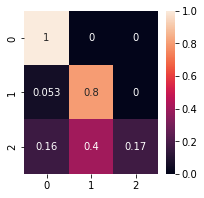

In [46]:
plt.figure(figsize = (3,3))
sn.heatmap(df_cm, annot=True)
plt.show()

In [64]:
print(metrics.classification_report(df['label'], df['BERT_label'], digits=3))

              precision    recall  f1-score   support

           0      0.826     1.000     0.905        19
           1      0.667     0.800     0.727         5
           2      1.000     0.167     0.286         6

    accuracy                          0.800        30
   macro avg      0.831     0.656     0.639        30
weighted avg      0.834     0.800     0.751        30

